<a href="https://colab.research.google.com/github/PurusottamReddy/plantdiseasepredict/blob/main/Plant_Disease_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORTING LIBRARIES**

In [ ]:
import os
import json
import random
import cv2
from zipfile import ZipFile

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout,BatchNormalization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

**IMPORTING DATASET USING KAGGLE**

In [ ]:
!pip install kaggle

In [ ]:
kaggle_credentials = json.load(open("kaggle.json"))

In [ ]:
os.environ['KAGGLE_USERNAME'] = kaggle_credentials['username']
os.environ['KAGGLE_KEY'] = kaggle_credentials['key']

In [ ]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors
100% 2.70G/2.70G [01:56<00:00, 16.9MB/s]
100% 2.70G/2.70G [01:56<00:00, 24.9MB/s]


In [ ]:
!ls

kaggle.json  new-plant-diseases-dataset.zip  sample_data


In [ ]:
# Unzip the downloaded dataset
with ZipFile("new-plant-diseases-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall()

**KNOWING THE DATASET**

#### About Dataset
            
                1. train (70295 images)
                2. test (33 images)
                3. validation (17572 images)

In [ ]:
data_dir = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"
diseases = os.listdir(train_dir)

In [ ]:
print(diseases)

['Apple___Black_rot', 'Tomato___Leaf_Mold', 'Tomato___Bacterial_spot', 'Potato___Late_blight', 'Cherry_(including_sour)___healthy', 'Soybean___healthy', 'Blueberry___healthy', 'Tomato___Late_blight', 'Apple___healthy', 'Potato___Early_blight', 'Pepper,_bell___healthy', 'Pepper,_bell___Bacterial_spot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Strawberry___Leaf_scorch', 'Tomato___healthy', 'Tomato___Tomato_mosaic_virus', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Apple___Apple_scab', 'Peach___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Tomato___Early_blight', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Target_Spot', 'Grape___Esca_(Black_Measles)', 'Apple___Cedar_apple_rust', 'Strawberry___healthy', 'Tomato___Septoria_leaf_spot', 'Corn_(maize)___healthy', 'Potato___healthy', 'Grape___Black_rot', 'Squash___Powdery_mil

In [ ]:
print("Total disease classes are: {}".format(len(diseases)))

Total disease classes are: 38


In [ ]:
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1

In [ ]:
print(f"Unique Plants are: \n{plants}")
print("Number of plants: {}".format(len(plants)))

Unique Plants are: 
['Apple', 'Tomato', 'Potato', 'Cherry_(including_sour)', 'Soybean', 'Blueberry', 'Pepper,_bell', 'Corn_(maize)', 'Strawberry', 'Peach', 'Grape', 'Squash', 'Orange', 'Raspberry']
Number of plants: 14


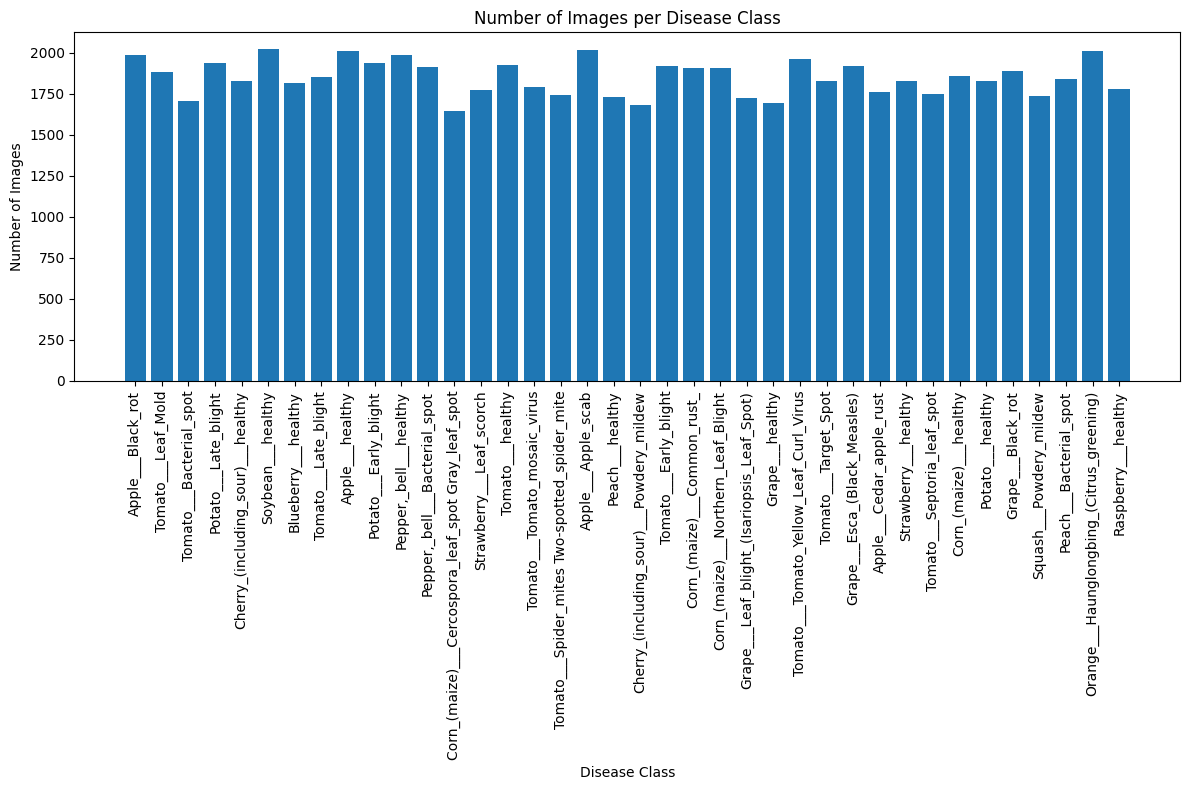

In [ ]:
# Number of images for each disease
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])

plt.figure(figsize=(12, 8))

plt.bar(img_per_class.index, img_per_class['no. of images'])
plt.xlabel('Disease Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Disease Class')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Adjust layout to prevent label overlapping
plt.tight_layout()

plt.show()


We can see that the dataset is almost balanced for all classes, so we are good to go forward

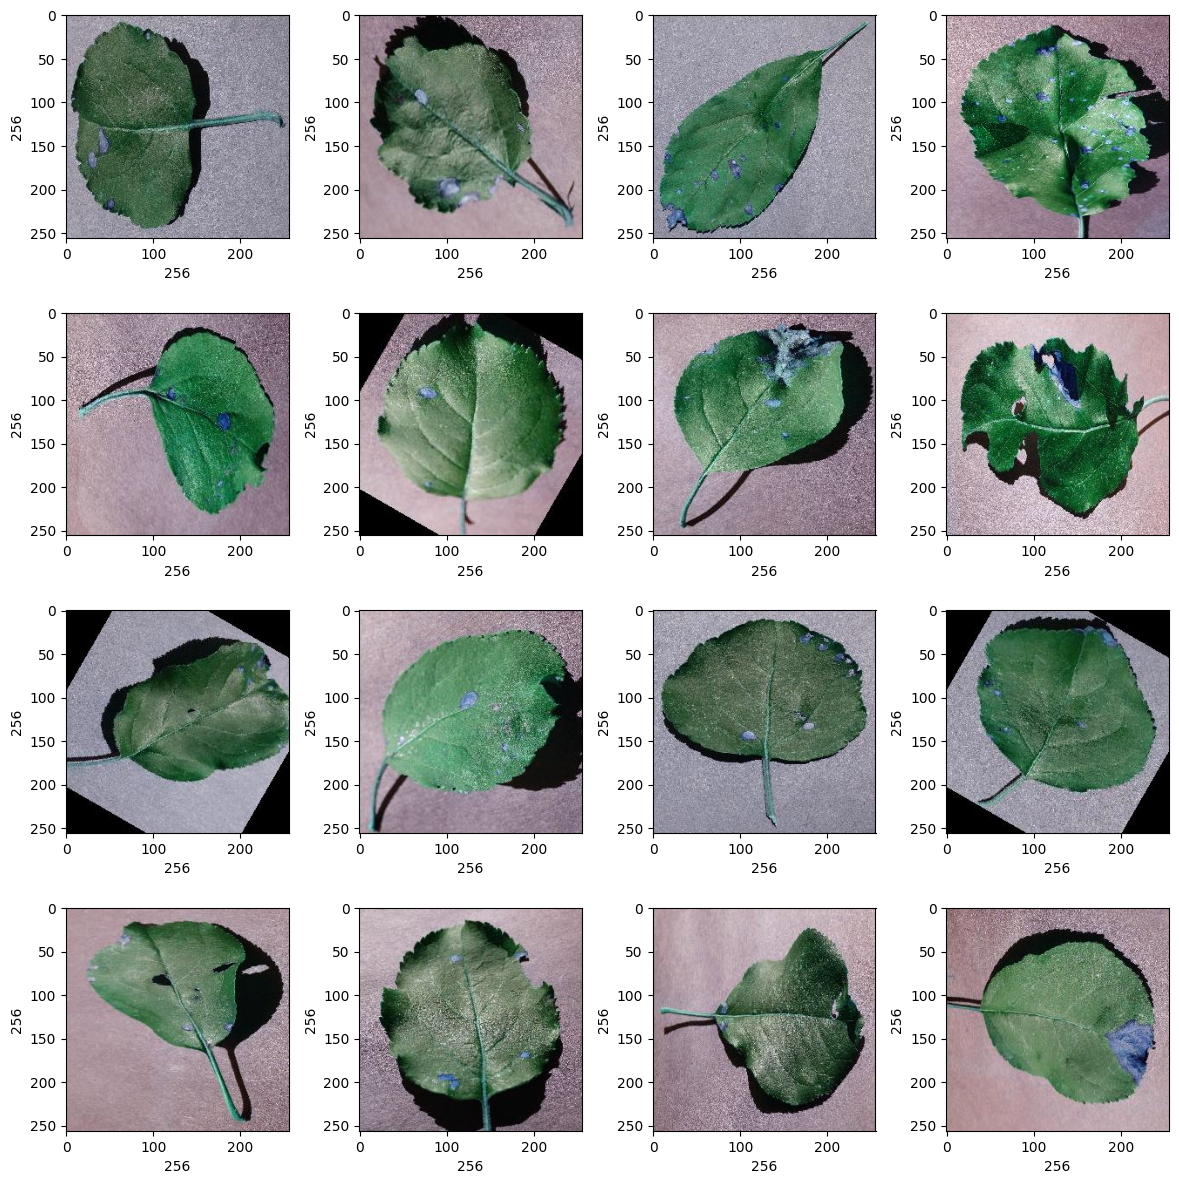

In [ ]:
# Plotting 12 images to check dataset

plt.figure(figsize = (12, 12))
dataset_path = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Black_rot"
for i in range(1, 17):
    plt.subplot(4, 4, i)
    plt.tight_layout()
    rand_img = cv2.imread(dataset_path +'/'+ random.choice(sorted(os.listdir(dataset_path)))) # Use cv2.imread to read the image
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10) # width of image
    plt.ylabel(rand_img.shape[0], fontsize = 10) # height of image

[[[141 138 154]
  [143 140 156]
  [139 136 152]
  ...
  [161 158 173]
  [153 150 165]
  [155 152 167]]

 [[139 136 152]
  [145 142 158]
  [144 141 157]
  ...
  [143 140 155]
  [143 140 155]
  [155 152 167]]

 [[134 131 147]
  [146 143 159]
  [146 143 159]
  ...
  [136 133 148]
  [138 135 150]
  [152 149 164]]

 ...

 [[ 73  71  83]
  [149 147 159]
  [175 173 185]
  ...
  [147 140 153]
  [167 160 173]
  [165 158 171]]

 [[152 152 164]
  [174 174 186]
  [162 162 174]
  ...
  [153 146 159]
  [151 144 157]
  [149 142 155]]

 [[135 137 148]
  [141 143 154]
  [131 131 143]
  ...
  [187 180 193]
  [172 165 178]
  [158 151 164]]]
(256, 256, 3)


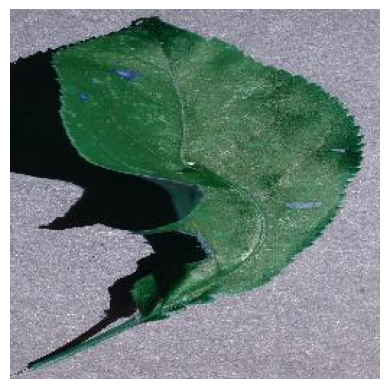

In [ ]:
image_path = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Black_rot/0090d05d-d797-4c99-abd4-3b9cb323a5fd___JR_FrgE.S 8727.JPG'
# Read the image
img = cv2.imread(image_path)

print(img)
print(img.shape)
# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers
plt.show()

# **DATA PREPROCESSING**

**TRAINING IMG PREPROCESSING**

In [ ]:
training_set = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 70295 files belonging to 38 classes.


**VALIDATION IMAGE PREPROCESSING**

In [ ]:
validation_set = tf.keras.utils.image_dataset_from_directory(
    valid_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 17572 files belonging to 38 classes.


**BUILDING MODEL**

In [ ]:
model=Sequential()

model.add(Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',input_shape=[128,128,3]))
model.add(Conv2D(filters=32,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2,strides=2))

model.add(Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=64,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2,strides=2))

model.add(Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=128,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2,strides=2))

model.add(Conv2D(filters=256,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=256,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2,strides=2))


model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=150,activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(units=38,activation='softmax'))  ## output layer

**COMPILING AND TRAINING PHASE**

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)                   │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 126, 126, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 63, 63, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 61, 61, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 30, 30, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 14, 14, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 150)                 │       1,382,550 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,562,464 (9.78 MB)

 Trainable params: 2,561,504 (9.77 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
training_history = model.fit(training_set,validation_data=validation_set,epochs=10)

Epoch 1/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 125s 54ms/step - accuracy: 0.5200 - loss: 1.7670 - val_accuracy: 0.7050 - val_loss: 0.9899
Epoch 2/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 131s 50ms/step - accuracy: 0.8497 - loss: 0.4855 - val_accuracy: 0.7996 - val_loss: 0.6670
Epoch 3/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 142s 50ms/step - accuracy: 0.9102 - loss: 0.2751 - val_accuracy: 0.8962 - val_loss: 0.3603
Epoch 4/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 150s 54ms/step - accuracy: 0.9373 - loss: 0.1897 - val_accuracy: 0.9347 - val_loss: 0.2204
Epoch 5/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 112s 51ms/step - accuracy: 0.9524 - loss: 0.1459 - val_accuracy: 0.9214 - val_loss: 0.2698
Epoch 6/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 120s 55ms/step - accuracy: 0.9613 - loss: 0.1140 - val_accuracy: 0.9025 - val_loss: 0.3632
Epoch 7/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 133s 51ms/step - accuracy: 0.9700 - loss: 0.0923 - val_accuracy: 0.9536 - val_loss: 0.1494
Epoch 8/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 120s 55ms/step - accuracy: 

**EVALUATING MODEL**

In [ ]:
# Model Evaluation
print("Evaluating model...")

train_loss, train_acc = model.evaluate(training_set)
print('Training accuracy:', train_acc)

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 56s 25ms/step - accuracy: 0.9693 - loss: 0.0938
Training accuracy: 0.9708229899406433


In [ ]:
val_loss, val_accuracy = model.evaluate(validation_set)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

Evaluating model...
550/550 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.9464 - loss: 0.1959
Validation Accuracy: 94.66%


MODEL TRAINING ACCURACY : 97.08%

MODEL VALIDATION ACCURACY : 94.66%

# **ACCURACY AND LOSS VISUALIZATION**

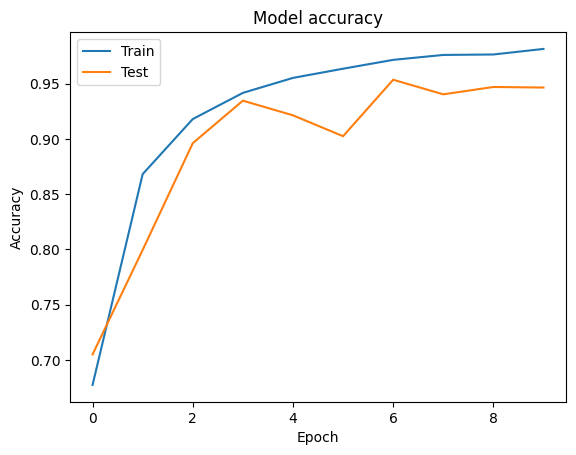

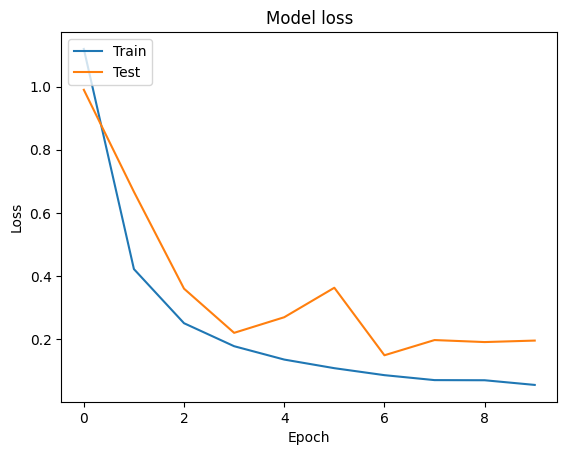

In [ ]:
# Plot training & validation accuracy values
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**SAVING MODEL**

In [ ]:
model.save('trained_plant_disease_model.keras')

In [ ]:
model.save('trained_plant_disease_model.h5')

In [ ]:
training_history.history #Return Dictionary of history

{'accuracy': [0.6773739457130432,
  0.8681840896606445,
  0.9180454015731812,
  0.9417312741279602,
  0.9552884101867676,
  0.9636104702949524,
  0.9716196060180664,
  0.9760722517967224,
  0.9764848351478577,
  0.9815207123756409],
 'loss': [1.1193773746490479,
  0.4222385287284851,
  0.25085029006004333,
  0.1780601590871811,
  0.135763481259346,
  0.10847922414541245,
  0.08637706190347672,
  0.07071986049413681,
  0.07026087492704391,
  0.0554744191467762],
 'val_accuracy': [0.7049852013587952,
  0.7995675206184387,
  0.8961985111236572,
  0.934668779373169,
  0.9214090704917908,
  0.9025153517723083,
  0.9536194205284119,
  0.9404165744781494,
  0.9470748901367188,
  0.9465627074241638],
 'val_loss': [0.9899454712867737,
  0.6669802069664001,
  0.3602514863014221,
  0.22039541602134705,
  0.269778311252594,
  0.3631783723831177,
  0.14935199916362762,
  0.19752556085586548,
  0.19118037819862366,
  0.19587910175323486]}

In [ ]:
#Recording History in json
import json
with open('training_hist.json','w') as f:
  json.dump(training_history.history,f)

In [ ]:
print(training_history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [ ]:
class_name = validation_set.class_names

 **Some other metrics for model evaluation**

In [ ]:
test_set = tf.keras.utils.image_dataset_from_directory(
    valid_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=1,
    image_size=(128, 128),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 17572 files belonging to 38 classes.


In [ ]:
y_pred = model.predict(test_set)
predicted_categories = tf.argmax(y_pred, axis=1)

17572/17572 ━━━━━━━━━━━━━━━━━━━━ 49s 3ms/step


In [ ]:
true_categories = tf.concat([y for x, y in test_set], axis=0)
Y_true = tf.argmax(true_categories, axis=1)

In [ ]:
Y_true

<tf.Tensor: shape=(17572,), dtype=int64, numpy=array([ 0,  0,  0, ..., 37, 37, 37])>

In [ ]:
predicted_categories

<tf.Tensor: shape=(17572,), dtype=int64, numpy=array([ 0,  0,  0, ..., 37, 37, 37])>

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report

In [ ]:
# Precision Recall Fscore
print(classification_report(Y_true,predicted_categories,target_names=class_name))

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.98      0.97      0.97       504
                                 Apple___Black_rot       0.99      0.96      0.98       497
                          Apple___Cedar_apple_rust       0.94      1.00      0.97       440
                                   Apple___healthy       0.99      0.95      0.97       502
                               Blueberry___healthy       0.93      0.98      0.96       454
          Cherry_(including_sour)___Powdery_mildew       0.95      1.00      0.97       421
                 Cherry_(including_sour)___healthy       0.99      0.95      0.97       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.88      0.98      0.92       410
                       Corn_(maize)___Common_rust_       0.99      0.99      0.99       477
               Corn_(maize)___Northern_Leaf_Blight       0.97      0.92      0.

**CONFUSION MATRIX**

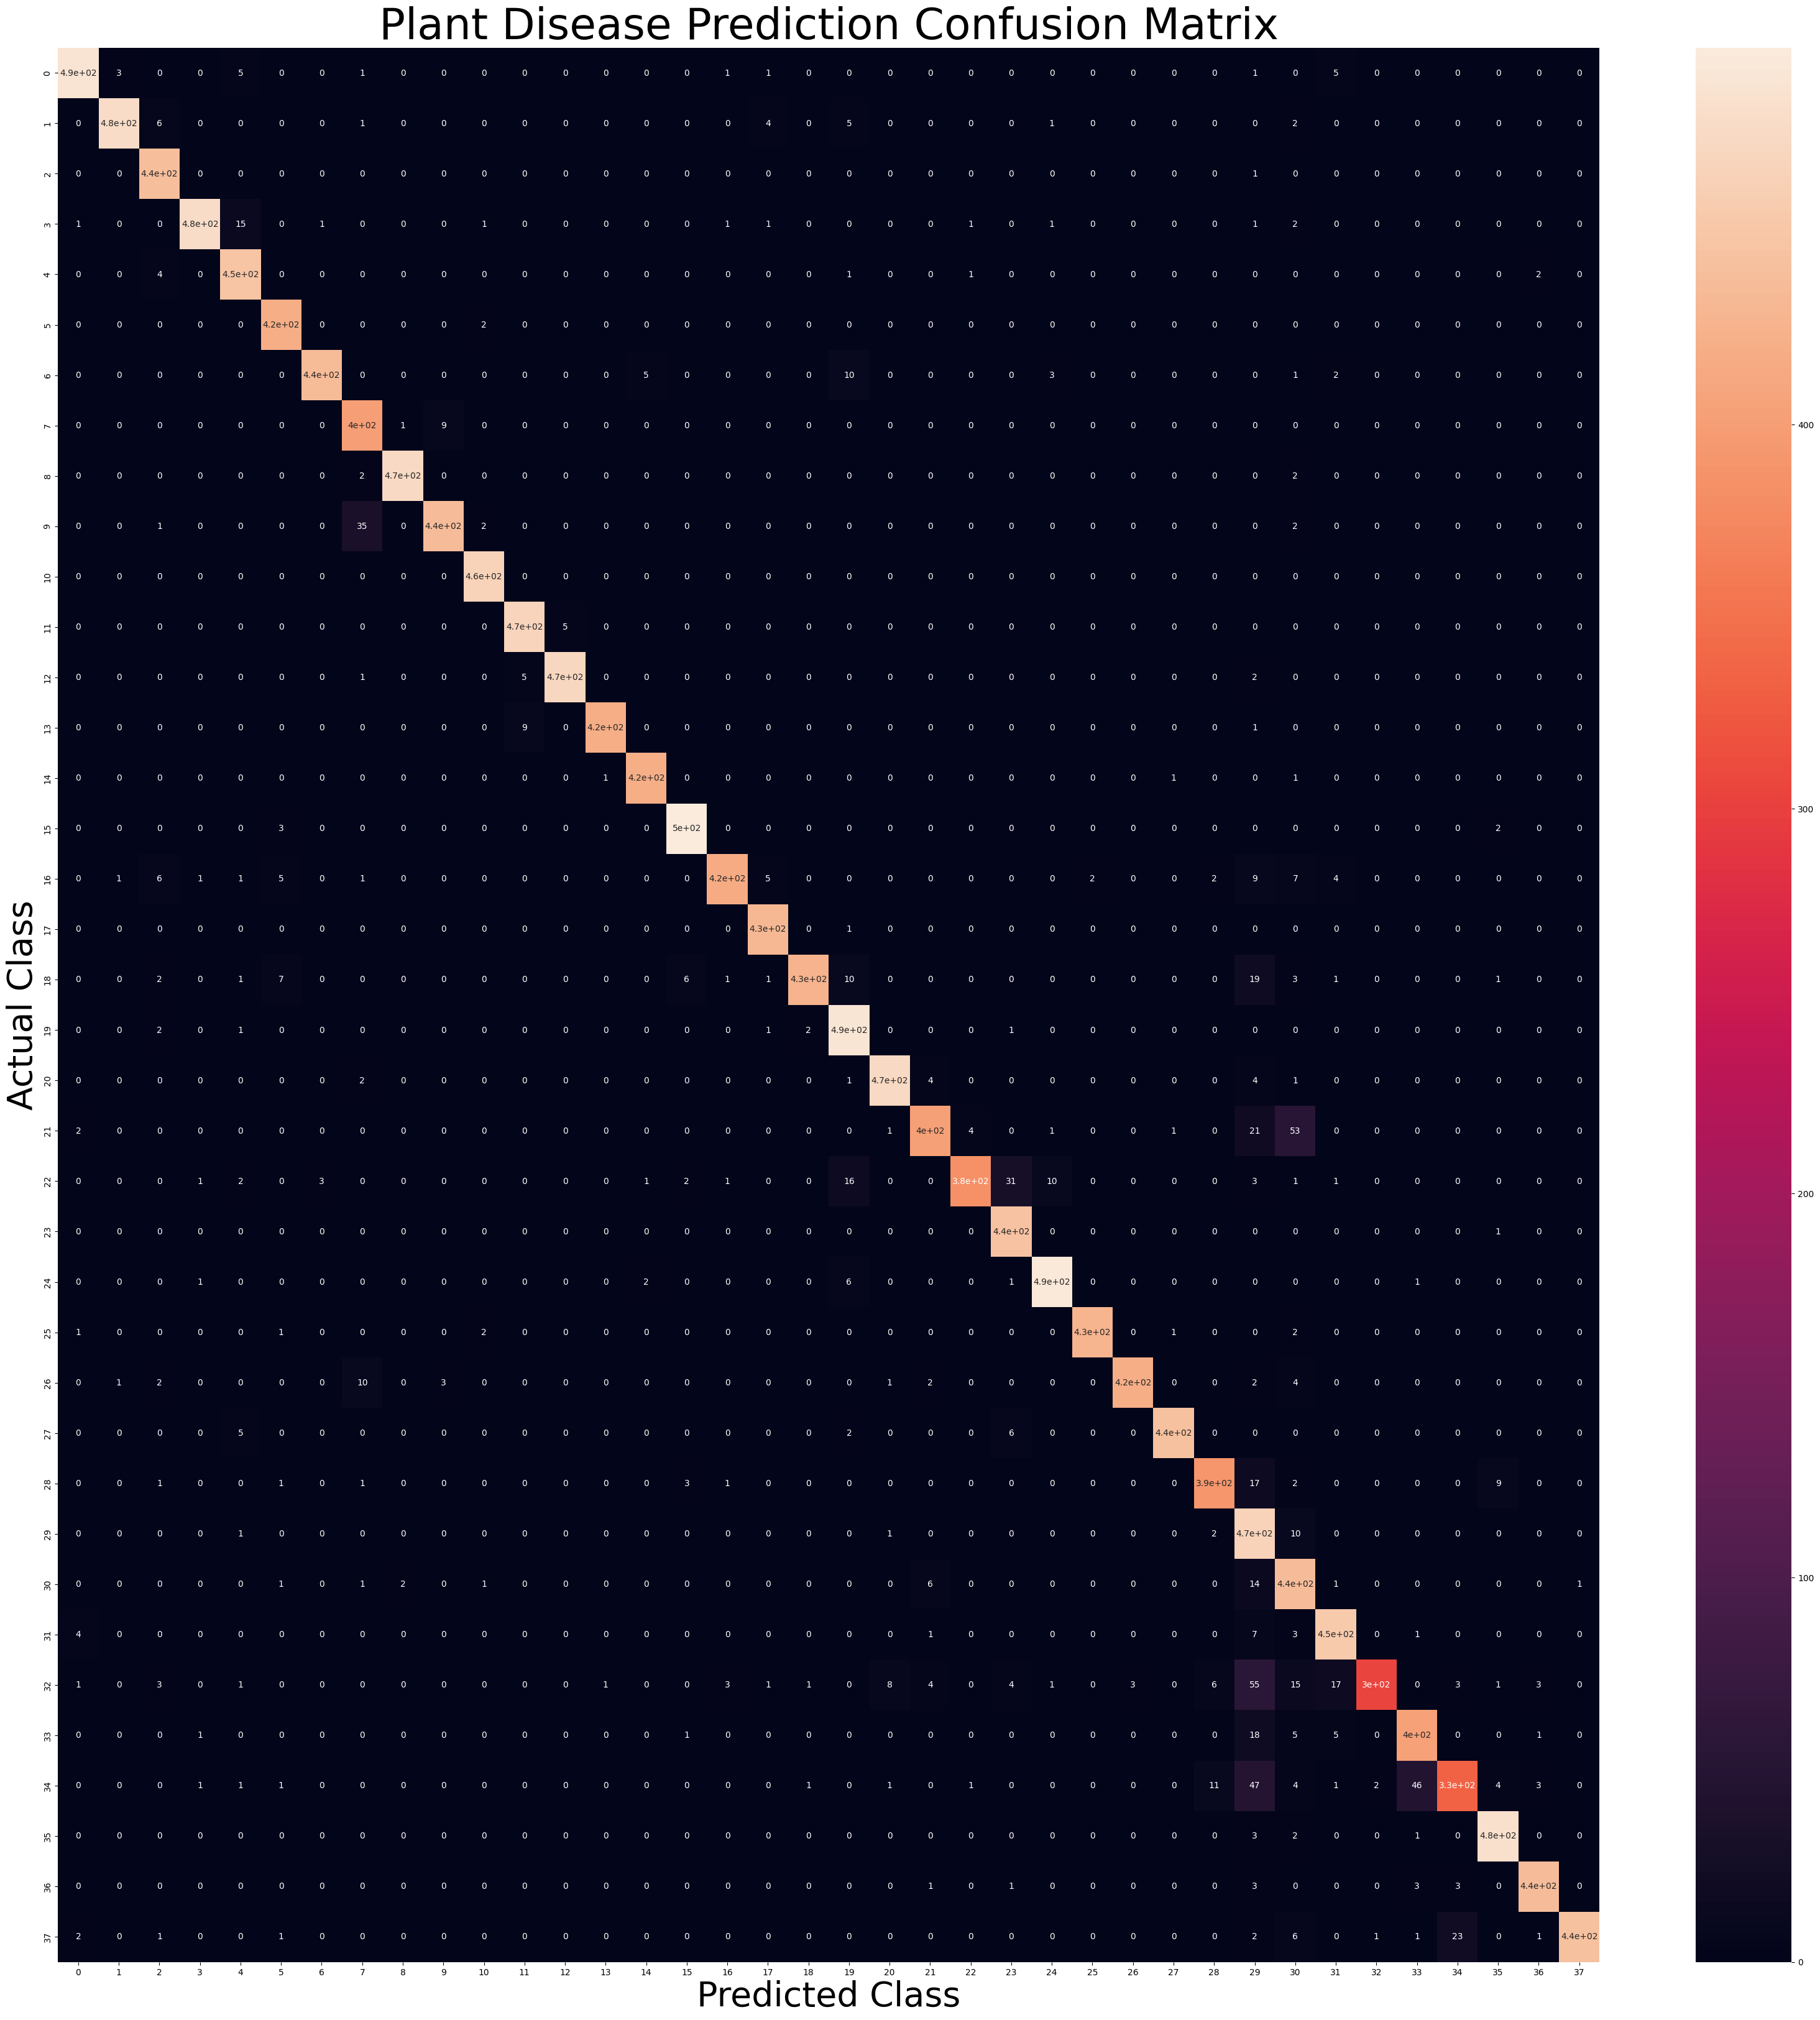

In [ ]:
cm = confusion_matrix(Y_true,predicted_categories)
plt.figure(figsize=(40, 40))
sns.heatmap(cm,annot=True,annot_kws={"size": 10})

plt.xlabel('Predicted Class',fontsize = 40)
plt.ylabel('Actual Class',fontsize = 40)
plt.title('Plant Disease Prediction Confusion Matrix',fontsize = 50)
plt.show()

**TESTING MODEL**

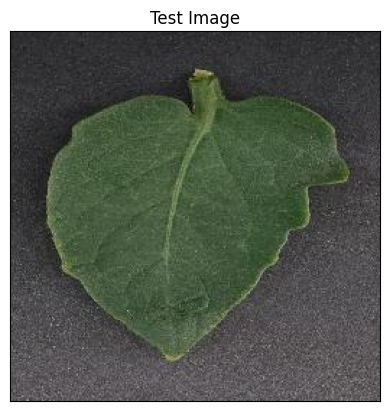

In [ ]:
#Test Image Visualization
image_path = '/content/test/test/TomatoHealthy2.JPG'
# Reading an image in default mode
img = cv2.imread(image_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) #Converting BGR to RGB
# Displaying the image
plt.imshow(img)
plt.title('Test Image')
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
image = tf.keras.preprocessing.image.load_img(image_path,target_size=(128,128))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = model.predict(input_arr)

result_index = np.argmax(predictions) #Return index of max element
print(result_index)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
37


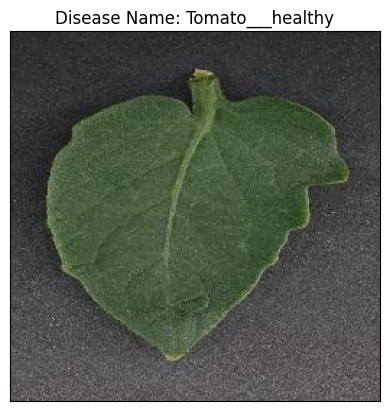

In [ ]:
# Displaying the disease prediction
model_prediction = class_name[result_index]
plt.imshow(img)
plt.title(f"Disease Name: {model_prediction}")
plt.xticks([])
plt.yticks([])
plt.show()